In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

np.random.seed(9000)

In this notebook we calculate `mean average precision` for a subset of the plates (U2OS at the longest time point) whose features were extracted using a pre-trained neural network. The following are the steps taken
1. Augmented ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe.
2. The augmented ORF, CRISPR and Compound profiles are spherized separately.
3. Empty wells are removed from the dataframe.
4. Average precision (AP) is computed for each replicate of each perturbation to the task of retrieving replicates against negcons. Mean average precision (mAP) is computed for each perturbation.
5. The AP of a random classifier is subtracted from each perturbation's AP.
6. Table of AP values is printed and bar plot of AP is plotted.

In [2]:
cell = "U2OS"
precision_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
batch = "2020_11_04_CPJUMP1_DL"
all_percent_perturbation_df = pd.DataFrame()

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
)

In [3]:
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query('Perturbation==@modality')
    for time_point in modality_df.Time.unique():
        time_df = modality_df.query('Time==@time_point')
        all_plates_df = pd.DataFrame()
        for plate in time_df.Assay_Plate_Barcode.unique():
            plate_df = utils.load_data(batch, plate, "spherized.csv.gz")
            all_plates_df = utils.concat_profiles(all_plates_df, plate_df)

        if modality == "compound":
                all_plates_df[group_by_feature].fillna("DMSO", inplace=True)

        all_plates_df = utils.remove_empty_wells(all_plates_df)

        score = utils.PrecisionScores(all_plates_df, all_plates_df, group_by_feature, within=True, challenge_negcon=True)

        precision_df = precision_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                            'Modality':f'{modality}',
                                            'Cell':f'{cell}',
                                            'time':f'{time_point}',
                                            'mAP':f'{score.map:.3f}'}, ignore_index=True)

In [4]:
print(precision_df[['Description', 'mAP']].to_markdown(index=False))

| Description      |   mAP |
|:-----------------|------:|
| compound_U2OS_48 | 0.532 |
| crispr_U2OS_144  | 0.32  |
| orf_U2OS_96      | 0.277 |


In [5]:
precision_df['mAP'] = precision_df['mAP'].astype(float)

precision_df.loc[(precision_df.Modality=='compound') & (precision_df.time=='24'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='compound') & (precision_df.time=='48'), 'time'] = 'long'
precision_df.loc[(precision_df.Modality=='crispr') & (precision_df.time=='96'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='crispr') & (precision_df.time=='144'), 'time'] = 'long'
precision_df.loc[(precision_df.Modality=='orf') & (precision_df.time=='48'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='orf') & (precision_df.time=='96'), 'time'] = 'long'

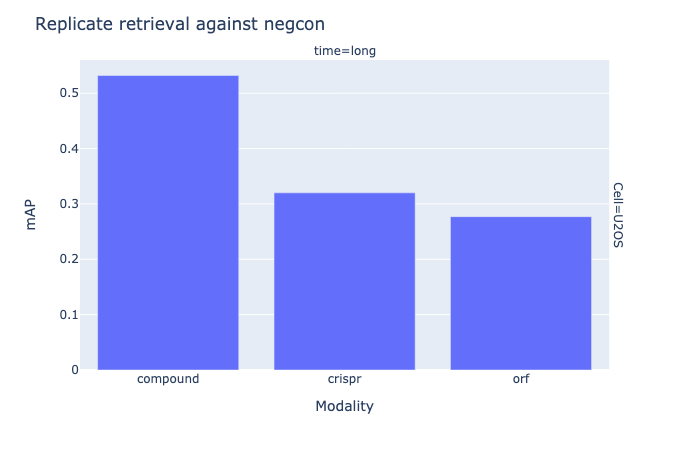

In [6]:
fig = px.bar(data_frame=precision_df,
             x='Modality',
             y='mAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='Replicate retrieval against negcon',
                  yaxis=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/6.mAP_DeepProfiler.png', width=640, height=480, scale=2)

In [7]:
precision_df[['Modality','Cell','time','mAP']].to_csv('output/deepprofiler_precision_score_negcon.csv', index=False)